In [1]:
!rm -rf ./KMT
!git clone https://www.github.com/abhaskumarsinha/KMT.git
%cd KMT
!pip install --upgrade tensorflow
!pip install --upgrade keras

Cloning into 'KMT'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 218 (delta 44), reused 39 (delta 39), pack-reused 171 (from 1)
Receiving objects: 100% (218/218), 968.00 KiB | 21.04 MiB/s, done.
Resolving deltas: 100% (121/121), done.
/kaggle/working/KMT
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 2.8 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    

In [2]:
from src.utils import *
from src.models import *

In [3]:
video_dataset = VideoDataLoader('../../../kaggle/input/voxpartial',
                               max_frames = 50,
                               num_vids = 25)
videos = video_dataset.get_batch()
video_dataset.get_stats()
(X0, X1), Y = create_dataset(videos)

In [4]:
# ── build the “double-mini-UNet” inline ──
inputs = keras.Input(shape=(60, 60, 22))

# Encoder
c1 = keras.layers.Conv2D(80, 3, padding='same', activation='relu')(inputs)   # 40 → 80
c1 = keras.layers.Conv2D(112, 3, padding='same', activation='tanh')(c1)      # 56 → 112
p1 = keras.layers.MaxPooling2D((2, 2))(c1)

# Bottleneck
b = keras.layers.Conv2D(112, 3, padding='same', activation='tanh')(p1)       # 56 → 112
b = keras.layers.Conv2D(112, 3, padding='same', activation='tanh')(b)        # 56 → 112

# Decoder
u1 = keras.layers.UpSampling2D((2, 2))(b)
u1 = keras.layers.Concatenate()([u1, c1])
c2 = keras.layers.Conv2D(112, 3, padding='same', activation='tanh')(u1)      # 56 → 112
c2 = keras.layers.Conv2D(80, 3, padding='same', activation='relu')(c2)       # 40 → 80

# Output
outputs = keras.layers.Conv2D(11, 1, activation='linear')(c2)

# assign to self.model
model = keras.Model(inputs, outputs)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60, 60, 22)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 60, 60, 80)     │         15,920 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 60, 60, 112)    │         80,752 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 112)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 30, 30, 112)    │        113,008 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 112)    │        113,008 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 60, 60, 112)    │              0 │ conv2d_3[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 60, 60, 224)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 60, 60, 112)    │        225,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 60, 60, 80)     │         80,720 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 60, 60, 11)     │            891 │ conv2d_5[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 630,203 (2.40 MB)

 Trainable params: 630,203 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ── build a “double-mini-UNet” upscaler inline ──
inp = keras.Input(shape=(60, 60, 1))

# Encoder (downsample once)
c1 = keras.layers.Conv2D(160, 3, padding='same', activation='relu')(inp)   #  80 → 160
c1 = keras.layers.Conv2D(200, 3, padding='same', activation='tanh')(c1)    # 100 → 200
p1 = keras.layers.MaxPooling2D((2, 2))(c1)                                 # → 30×30

# Bottleneck
b  = keras.layers.Conv2D(200, 3, padding='same', activation='tanh')(p1)    # 100 → 200
b  = keras.layers.Conv2D(200, 3, padding='same', activation='tanh')(b)     # 100 → 200

# Decoder (upsample back to 60×60)
u1 = keras.layers.UpSampling2D((2, 2))(b)                                  # → 60×60
u1 = keras.layers.Concatenate()([u1, c1])
c2 = keras.layers.Conv2D(200, 3, padding='same', activation='tanh')(u1)    # 100 → 200
c2 = keras.layers.Conv2D(160, 3, padding='same', activation='relu')(c2)    #  80 → 160   → 60×60

# Two more upsampling steps to expand resolution
u2 = keras.layers.UpSampling2D((2, 2))(c2)                                 # → 120×120
c3 = keras.layers.Conv2D(160, 3, padding='same', activation='tanh')(u2)    #  80 → 160

u3 = keras.layers.UpSampling2D((2, 2))(c3)                                 # → 240×240
c4 = keras.layers.Conv2D(10,  3, padding='same', activation='relu')(u3)    #   5 → 10

# Final output conv + resize to 256×256
out = keras.layers.Conv2D(1, 3, padding='same', activation='sigmoid')(c4)
out = keras.layers.Resizing(256, 256, interpolation='bilinear')(out)

upscaler = keras.Model(inp, out)
upscaler.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 60, 60, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 60, 60, 160)    │          1,600 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 60, 60, 200)    │        288,200 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 200)    │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 30, 30, 200)    │        360,200 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 30, 30, 200)    │        360,200 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 60, 60, 200)    │              0 │ conv2d_10[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 60, 60, 400)    │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 60, 60, 200)    │        720,200 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 60, 60, 160)    │        288,160 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 120, 120, 160)  │              0 │ conv2d_12[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 120, 120, 160)  │        230,560 │ up_sampling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 240, 240, 160)  │              0 │ conv2d_13[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 240, 240, 10)   │         14,410 │ up_sampling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 240, 240, 1)    │             91 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing (Resizing)       │ (None, 256, 256, 1)    │              0 │ conv2d_15[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,263,621 (8.64 MB)

 Trainable params: 2,263,621 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
kp_detector = KeypointDetector()
generator = KeypointBasedTransform(batch_size = 16, model=model, upscaler=upscaler)
discriminator = build_discriminator(base_filters=32, num_blocks=5)

models = setup_keypoint_pipeline(
    keypoint_detector = kp_detector,
    generator = generator,
    discriminator_model = discriminator,
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.4264
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0569
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0114
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0116
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0033
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0014
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.0908e-04
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.4608e-04
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.4777e-05
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.8035e-05

🧱 GAN Summary:


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_25            │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keypoint_detector_3       │ [(None, 10, 2), (None, │         33,586 │ input_layer_24[0][0],  │
│ (KeypointDetector)        │ 10, 2, 2)]             │                │ input_layer_25[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keypoint_based_transform… │ (16, 256, 256, 1)      │      2,895,024 │ input_layer_24[0][0],  │
│ (KeypointBasedTransform)  │                        │                │ keypoint_detector_3[1… │
│                           │                        │                │ keypoint_detector_3[1… │
│                           │                        │                │ keypoint_detector_3[2… │
│                           │                        │                │ keypoint_detector_3[2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Discriminator             │ (16, 1)                │      2,823,393 │ keypoint_based_transf… │
│ (Functional)              │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,752,003 (21.94 MB)

 Trainable params: 5,750,083 (21.93 MB)

 Non-trainable params: 1,920 (7.50 KB)


🧱 Generator Backbone Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60, 60, 22)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 60, 60, 80)     │         15,920 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 60, 60, 112)    │         80,752 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 112)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 30, 30, 112)    │        113,008 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 112)    │        113,008 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 60, 60, 112)    │              0 │ conv2d_3[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 60, 60, 224)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 60, 60, 112)    │        225,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 60, 60, 80)     │         80,720 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 60, 60, 11)     │            891 │ conv2d_5[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 630,203 (2.40 MB)

 Trainable params: 630,203 (2.40 MB)

 Non-trainable params: 0 (0.00 B)


🧱 Generator Upscaler Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 60, 60, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 60, 60, 160)    │          1,600 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 60, 60, 200)    │        288,200 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 200)    │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 30, 30, 200)    │        360,200 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 30, 30, 200)    │        360,200 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 60, 60, 200)    │              0 │ conv2d_10[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 60, 60, 400)    │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 60, 60, 200)    │        720,200 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 60, 60, 160)    │        288,160 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 120, 120, 160)  │              0 │ conv2d_12[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 120, 120, 160)  │        230,560 │ up_sampling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 240, 240, 160)  │              0 │ conv2d_13[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 240, 240, 10)   │         14,410 │ up_sampling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 240, 240, 1)    │             91 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing (Resizing)       │ (None, 256, 256, 1)    │              0 │ conv2d_15[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,263,621 (8.64 MB)

 Trainable params: 2,263,621 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
models['gan']((keras.ops.ones((16, 256, 256, 1)),
              keras.ops.ones((16, 256, 256, 1))))
models['gan'].load_weights('/kaggle/working/GAN.weights.h5')

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683],
       [0.31294683]], dtype=float32)>

Epochs:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 1/751


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Discriminator Loss (real): 0.024192343
GAN Loss (G): 6.436073
GAN Loss (D): 6.3948164


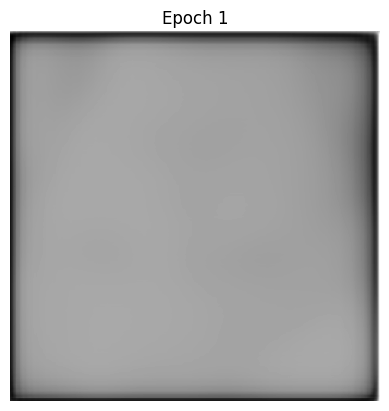

Epochs:   0%|          | 1/751 [05:25<67:42:51, 325.03s/it]

Epoch 2/751


Epochs:   0%|          | 2/751 [05:46<30:26:16, 146.30s/it]

Epoch 3/751


Epochs:   0%|          | 3/751 [06:07<18:31:35, 89.17s/it] 

Epoch 4/751


Epochs:   1%|          | 4/751 [06:28<12:55:54, 62.32s/it]

Epoch 5/751


Epochs:   1%|          | 5/751 [06:49<9:50:18, 47.48s/it] 

Epoch 6/751
Discriminator Loss (real): 0.0040350202
GAN Loss (G): 8.42288
GAN Loss (D): 8.413882


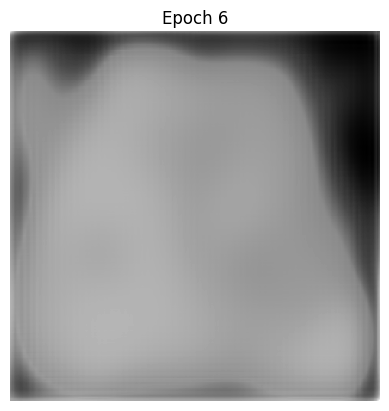

Epochs:   1%|          | 6/751 [07:13<8:09:27, 39.42s/it]

Epoch 7/751


Epochs:   1%|          | 7/751 [07:34<6:54:54, 33.46s/it]

Epoch 8/751


Epochs:   1%|          | 8/751 [07:55<6:05:52, 29.55s/it]

Epoch 9/751


Epochs:   1%|          | 9/751 [08:17<5:32:58, 26.93s/it]

Epoch 10/751


Epochs:   1%|▏         | 10/751 [08:38<5:10:38, 25.15s/it]

Epoch 11/751
Discriminator Loss (real): 0.0022021045
GAN Loss (G): 8.673148
GAN Loss (D): 8.668094


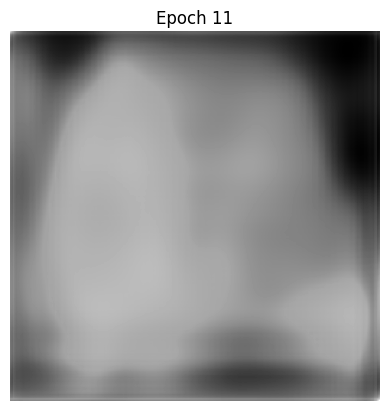

Epochs:   1%|▏         | 11/751 [09:02<5:05:11, 24.75s/it]

Epoch 12/751


Epochs:   2%|▏         | 12/751 [09:23<4:51:27, 23.66s/it]

Epoch 13/751


Epochs:   2%|▏         | 13/751 [09:44<4:41:45, 22.91s/it]

Epoch 14/751


Epochs:   2%|▏         | 14/751 [10:05<4:34:55, 22.38s/it]

Epoch 15/751


Epochs:   2%|▏         | 15/751 [10:26<4:30:01, 22.01s/it]

Epoch 16/751
Discriminator Loss (real): 0.0015145421
GAN Loss (G): 8.799111
GAN Loss (D): 8.795587


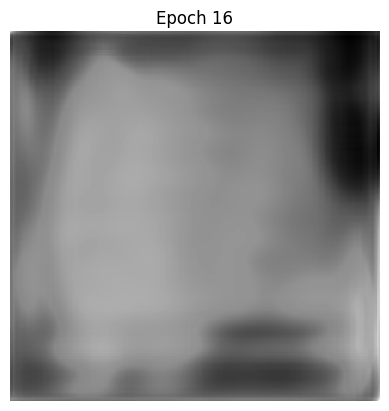

Epochs:   2%|▏         | 16/751 [10:50<4:36:17, 22.56s/it]

Epoch 17/751


Epochs:   2%|▏         | 17/751 [11:11<4:30:52, 22.14s/it]

Epoch 18/751


Epochs:   2%|▏         | 18/751 [11:32<4:26:59, 21.86s/it]

Epoch 19/751


Epochs:   3%|▎         | 19/751 [11:54<4:24:07, 21.65s/it]

Epoch 20/751


Epochs:   3%|▎         | 20/751 [12:15<4:22:03, 21.51s/it]

Epoch 21/751
Discriminator Loss (real): 0.0011542755
GAN Loss (G): 8.891511
GAN Loss (D): 8.888797


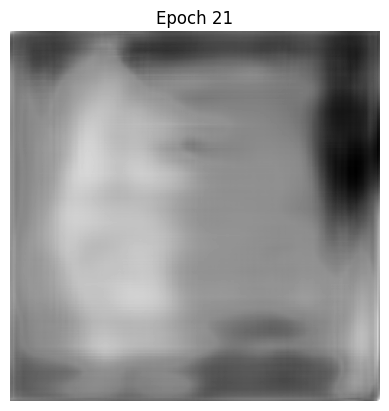

Epochs:   3%|▎         | 21/751 [12:39<4:30:05, 22.20s/it]

Epoch 22/751


Epochs:   3%|▎         | 22/751 [13:00<4:25:56, 21.89s/it]

Epoch 23/751


Epochs:   3%|▎         | 23/751 [13:21<4:22:53, 21.67s/it]

Epoch 24/751


Epochs:   3%|▎         | 24/751 [13:42<4:20:42, 21.52s/it]

Epoch 25/751


Epochs:   3%|▎         | 25/751 [14:03<4:19:06, 21.41s/it]

Epoch 26/751
Discriminator Loss (real): 0.00093250745
GAN Loss (G): 8.957258
GAN Loss (D): 8.95505


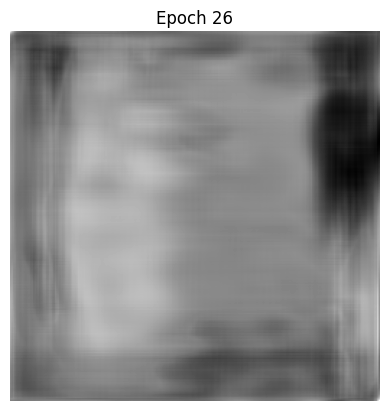

Epochs:   3%|▎         | 26/751 [14:27<4:27:36, 22.15s/it]

Epoch 27/751


Epochs:   4%|▎         | 27/751 [14:48<4:24:07, 21.89s/it]

Epoch 28/751


Epochs:   4%|▎         | 28/751 [15:10<4:21:48, 21.73s/it]

Epoch 29/751


Epochs:   4%|▍         | 29/751 [15:31<4:19:27, 21.56s/it]

Epoch 30/751


Epochs:   4%|▍         | 30/751 [15:52<4:17:41, 21.44s/it]

Epoch 31/751
Discriminator Loss (real): 0.00078223867
GAN Loss (G): 9.028263
GAN Loss (D): 9.026397


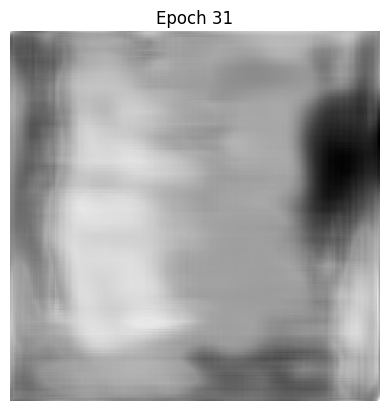

Epochs:   4%|▍         | 31/751 [16:16<4:25:45, 22.15s/it]

Epoch 32/751


Epochs:   4%|▍         | 32/751 [16:37<4:22:01, 21.87s/it]

Epoch 33/751


Epochs:   4%|▍         | 33/751 [16:58<4:19:15, 21.66s/it]

Epoch 34/751


Epochs:   5%|▍         | 34/751 [17:19<4:17:11, 21.52s/it]

Epoch 35/751


Epochs:   5%|▍         | 35/751 [17:41<4:15:43, 21.43s/it]

Epoch 36/751
Discriminator Loss (real): 0.00067368604
GAN Loss (G): 9.095695
GAN Loss (D): 9.094075


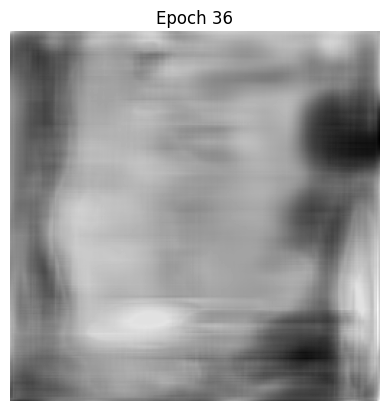

Epochs:   5%|▍         | 36/751 [18:05<4:24:06, 22.16s/it]

Epoch 37/751


Epochs:   5%|▍         | 37/751 [18:26<4:20:03, 21.85s/it]

Epoch 38/751


Epochs:   5%|▌         | 38/751 [18:47<4:17:06, 21.64s/it]

Epoch 39/751


Epochs:   5%|▌         | 39/751 [19:08<4:14:59, 21.49s/it]

Epoch 40/751


Epochs:   5%|▌         | 40/751 [19:29<4:13:23, 21.38s/it]

Epoch 41/751
Discriminator Loss (real): 0.00059159304
GAN Loss (G): 9.167675
GAN Loss (D): 9.166242


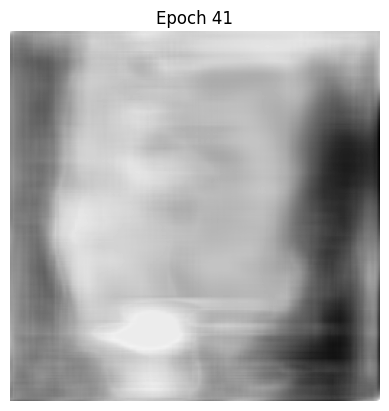

Epochs:   5%|▌         | 41/751 [19:53<4:21:37, 22.11s/it]

Epoch 42/751


Epochs:   6%|▌         | 42/751 [20:14<4:17:54, 21.83s/it]

Epoch 43/751


Epochs:   6%|▌         | 43/751 [20:35<4:15:12, 21.63s/it]

Epoch 44/751


Epochs:   6%|▌         | 44/751 [20:56<4:13:12, 21.49s/it]

Epoch 45/751


Epochs:   6%|▌         | 45/751 [21:18<4:11:45, 21.40s/it]

Epoch 46/751
Discriminator Loss (real): 0.0005273349
GAN Loss (G): 9.239761
GAN Loss (D): 9.238473


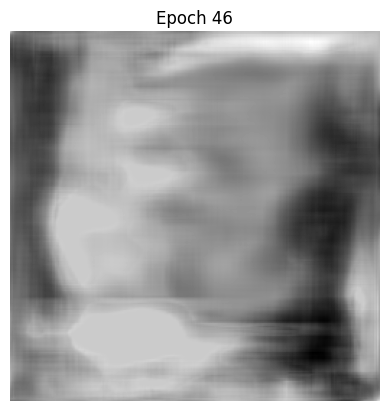

Epochs:   6%|▌         | 46/751 [21:41<4:19:47, 22.11s/it]

Epoch 47/751


Epochs:   6%|▋         | 47/751 [22:02<4:16:01, 21.82s/it]

Epoch 48/751


Epochs:   6%|▋         | 48/751 [22:24<4:13:16, 21.62s/it]

Epoch 49/751


Epochs:   7%|▋         | 49/751 [22:45<4:11:11, 21.47s/it]

Epoch 50/751


Epochs:   7%|▋         | 50/751 [23:06<4:09:40, 21.37s/it]

Epoch 51/751
Discriminator Loss (real): 0.0004756684
GAN Loss (G): 9.310211
GAN Loss (D): 9.309041


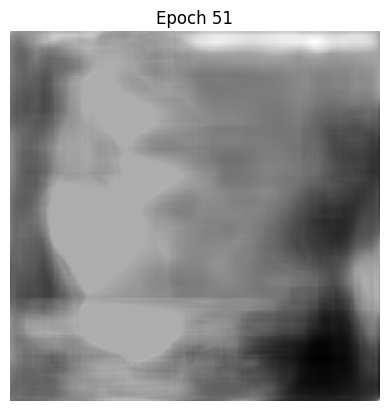

Epochs:   7%|▋         | 51/751 [23:30<4:17:47, 22.10s/it]

Epoch 52/751


Epochs:   7%|▋         | 52/751 [23:51<4:14:25, 21.84s/it]

Epoch 53/751


Epochs:   7%|▋         | 53/751 [24:12<4:11:46, 21.64s/it]

Epoch 54/751


Epochs:   7%|▋         | 54/751 [24:33<4:09:47, 21.50s/it]

Epoch 55/751


Epochs:   7%|▋         | 55/751 [24:54<4:08:16, 21.40s/it]

Epoch 56/751
Discriminator Loss (real): 0.00043322236
GAN Loss (G): 9.3743925
GAN Loss (D): 9.37332


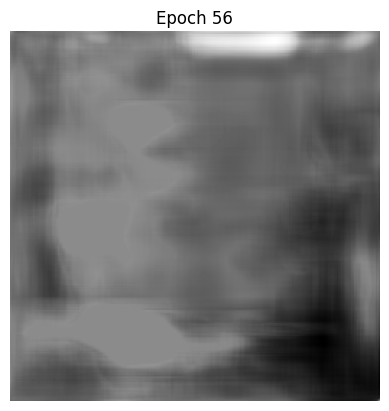

Epochs:   7%|▋         | 56/751 [25:18<4:16:25, 22.14s/it]

Epoch 57/751


Epochs:   8%|▊         | 57/751 [25:39<4:12:37, 21.84s/it]

Epoch 58/751


Epochs:   8%|▊         | 58/751 [26:01<4:09:47, 21.63s/it]

Epoch 59/751


Epochs:   8%|▊         | 59/751 [26:22<4:07:36, 21.47s/it]

Epoch 60/751


Epochs:   8%|▊         | 60/751 [26:43<4:06:03, 21.37s/it]

Epoch 61/751
Discriminator Loss (real): 0.00039773024
GAN Loss (G): 9.433644
GAN Loss (D): 9.432652


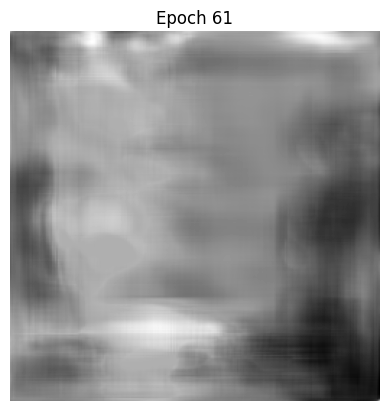

Epochs:   8%|▊         | 61/751 [27:07<4:14:01, 22.09s/it]

Epoch 62/751


Epochs:   8%|▊         | 62/751 [27:28<4:10:21, 21.80s/it]

Epoch 63/751


Epochs:   8%|▊         | 63/751 [27:49<4:07:36, 21.59s/it]

Epoch 64/751


Epochs:   9%|▊         | 64/751 [28:10<4:05:38, 21.45s/it]

Epoch 65/751


Epochs:   9%|▊         | 65/751 [28:31<4:04:04, 21.35s/it]

Epoch 66/751
Discriminator Loss (real): 0.00036761296
GAN Loss (G): 9.497724
GAN Loss (D): 9.496801


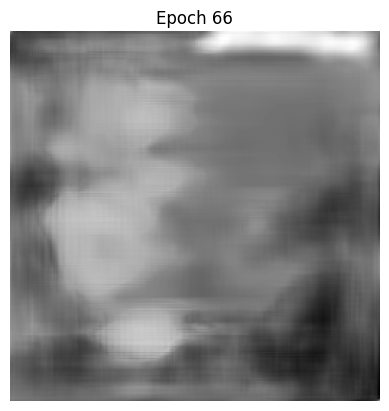

Epochs:   9%|▉         | 66/751 [28:55<4:11:52, 22.06s/it]

Epoch 67/751


Epochs:   9%|▉         | 67/751 [29:16<4:08:19, 21.78s/it]

Epoch 68/751


Epochs:   9%|▉         | 68/751 [29:37<4:05:44, 21.59s/it]

Epoch 69/751


Epochs:   9%|▉         | 69/751 [29:58<4:03:39, 21.44s/it]

Epoch 70/751


Epochs:   9%|▉         | 70/751 [30:19<4:02:12, 21.34s/it]

Epoch 71/751
Discriminator Loss (real): 0.00034173482
GAN Loss (G): 9.552761
GAN Loss (D): 9.551898


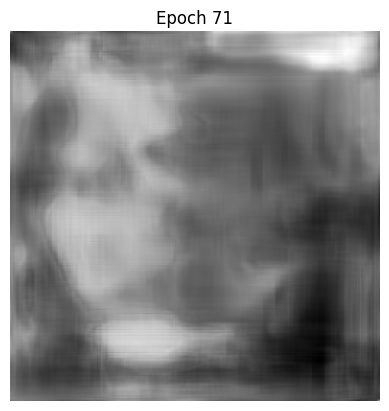

Epochs:   9%|▉         | 71/751 [30:43<4:11:42, 22.21s/it]

Epoch 72/751


Epochs:  10%|▉         | 72/751 [31:05<4:09:10, 22.02s/it]

Epoch 73/751


Epochs:  10%|▉         | 73/751 [31:27<4:07:05, 21.87s/it]

Epoch 74/751


Epochs:  10%|▉         | 74/751 [31:48<4:05:27, 21.75s/it]

Epoch 75/751


Epochs:  10%|▉         | 75/751 [32:09<4:03:57, 21.65s/it]

Epoch 76/751
Discriminator Loss (real): 0.0003192599
GAN Loss (G): 9.606689
GAN Loss (D): 9.60588


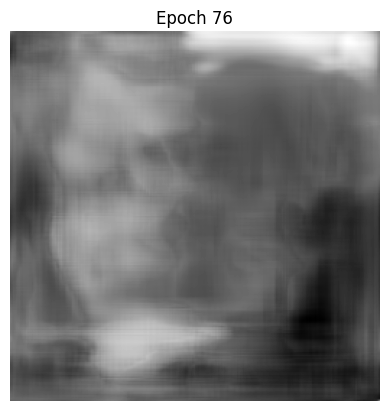

Epochs:  10%|█         | 76/751 [32:34<4:12:11, 22.42s/it]

Epoch 77/751


Epochs:  10%|█         | 77/751 [32:55<4:08:58, 22.16s/it]

Epoch 78/751


Epochs:  10%|█         | 78/751 [33:17<4:06:21, 21.96s/it]

Epoch 79/751


Epochs:  11%|█         | 79/751 [33:38<4:04:12, 21.80s/it]

Epoch 80/751


Epochs:  11%|█         | 80/751 [34:00<4:02:25, 21.68s/it]

Epoch 81/751
Discriminator Loss (real): 0.0002995584
GAN Loss (G): 9.658826
GAN Loss (D): 9.658062


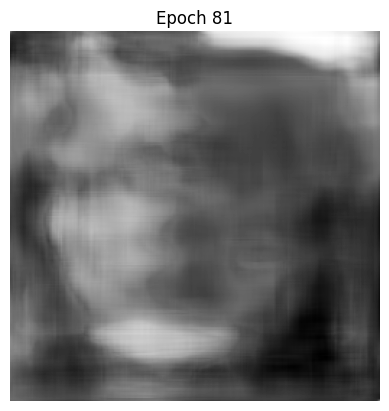

Epochs:  11%|█         | 81/751 [34:24<4:10:40, 22.45s/it]

Epoch 82/751


Epochs:  11%|█         | 82/751 [34:45<4:07:21, 22.18s/it]

Epoch 83/751


Epochs:  11%|█         | 83/751 [35:07<4:04:29, 21.96s/it]

Epoch 84/751


Epochs:  11%|█         | 84/751 [35:28<4:02:16, 21.79s/it]

Epoch 85/751


Epochs:  11%|█▏        | 85/751 [35:50<4:00:37, 21.68s/it]

Epoch 86/751
Discriminator Loss (real): 0.00028214688
GAN Loss (G): 9.712383
GAN Loss (D): 9.7116585


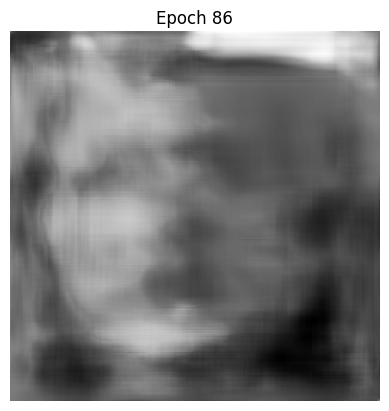

Epochs:  11%|█▏        | 86/751 [36:14<4:09:10, 22.48s/it]

Epoch 87/751


Epochs:  12%|█▏        | 87/751 [36:36<4:05:48, 22.21s/it]

Epoch 88/751


Epochs:  12%|█▏        | 88/751 [36:57<4:03:00, 21.99s/it]

Epoch 89/751


Epochs:  12%|█▏        | 89/751 [37:18<4:00:47, 21.82s/it]

Epoch 90/751


Epochs:  12%|█▏        | 90/751 [37:40<3:59:09, 21.71s/it]

Epoch 91/751
Discriminator Loss (real): 0.00026664804
GAN Loss (G): 9.7652235
GAN Loss (D): 9.764536


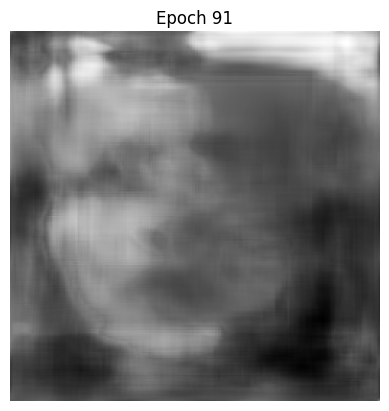

Epochs:  12%|█▏        | 91/751 [38:04<4:07:36, 22.51s/it]

Epoch 92/751


Epochs:  12%|█▏        | 92/751 [38:26<4:03:26, 22.16s/it]

Epoch 93/751


Epochs:  12%|█▏        | 93/751 [38:47<4:00:06, 21.89s/it]

Epoch 94/751


Epochs:  13%|█▎        | 94/751 [39:08<3:57:42, 21.71s/it]

Epoch 95/751


Epochs:  13%|█▎        | 95/751 [39:30<3:56:15, 21.61s/it]

Epoch 96/751
Discriminator Loss (real): 0.00025276293
GAN Loss (G): 9.816165
GAN Loss (D): 9.81551


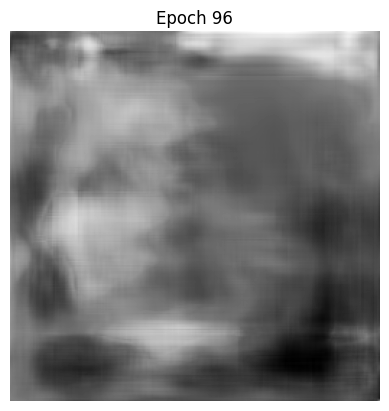

Epochs:  13%|█▎        | 96/751 [39:54<4:04:38, 22.41s/it]

Epoch 97/751


Epochs:  13%|█▎        | 97/751 [40:15<4:01:23, 22.15s/it]

Epoch 98/751


Epochs:  13%|█▎        | 98/751 [40:37<3:58:09, 21.88s/it]

Epoch 99/751


Epochs:  13%|█▎        | 99/751 [40:58<3:55:38, 21.68s/it]

Epoch 100/751


Epochs:  13%|█▎        | 100/751 [41:19<3:53:45, 21.54s/it]

Epoch 101/751
Discriminator Loss (real): 0.00024025208
GAN Loss (G): 9.867448
GAN Loss (D): 9.866821


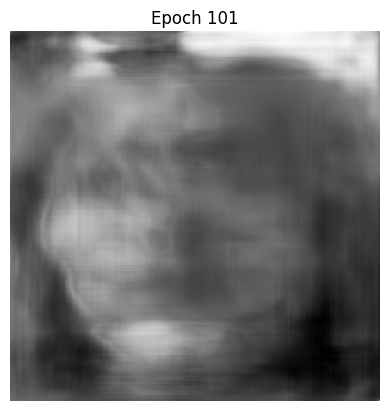

Epochs:  13%|█▎        | 101/751 [41:43<4:01:01, 22.25s/it]

Epoch 102/751


Epochs:  14%|█▎        | 102/751 [42:04<3:57:20, 21.94s/it]

Epoch 103/751


Epochs:  14%|█▎        | 103/751 [42:25<3:54:39, 21.73s/it]

Epoch 104/751


Epochs:  14%|█▍        | 104/751 [42:47<3:52:43, 21.58s/it]

Epoch 105/751


Epochs:  14%|█▍        | 105/751 [43:08<3:51:02, 21.46s/it]

Epoch 106/751
Discriminator Loss (real): 0.00022892098
GAN Loss (G): 9.915508
GAN Loss (D): 9.914909


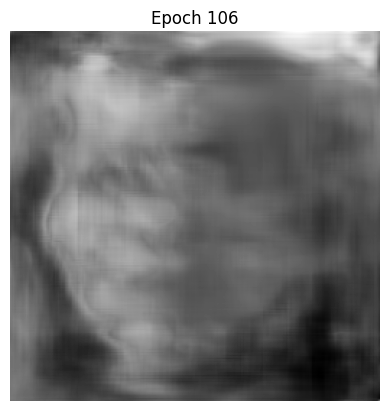

Epochs:  14%|█▍        | 106/751 [43:32<3:58:55, 22.23s/it]

Epoch 107/751


Epochs:  14%|█▍        | 107/751 [43:53<3:55:23, 21.93s/it]

Epoch 108/751


Epochs:  14%|█▍        | 108/751 [44:14<3:52:53, 21.73s/it]

Epoch 109/751


Epochs:  15%|█▍        | 109/751 [44:36<3:50:52, 21.58s/it]

Epoch 110/751


Epochs:  15%|█▍        | 110/751 [44:57<3:49:33, 21.49s/it]

Epoch 111/751
Discriminator Loss (real): 0.0002186104
GAN Loss (G): 9.960735
GAN Loss (D): 9.960159


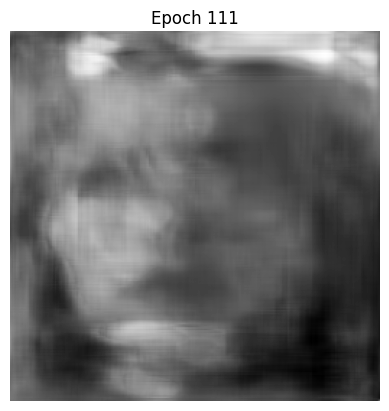

Epochs:  15%|█▍        | 111/751 [45:21<3:57:00, 22.22s/it]

Epoch 112/751


Epochs:  15%|█▍        | 112/751 [45:42<3:53:26, 21.92s/it]

Epoch 113/751


Epochs:  15%|█▌        | 113/751 [46:03<3:50:35, 21.69s/it]

Epoch 114/751


Epochs:  15%|█▌        | 114/751 [46:24<3:48:30, 21.52s/it]

Epoch 115/751


Epochs:  15%|█▌        | 115/751 [46:45<3:46:54, 21.41s/it]

Epoch 116/751
Discriminator Loss (real): 0.00020918835
GAN Loss (G): 10.006851
GAN Loss (D): 10.006298


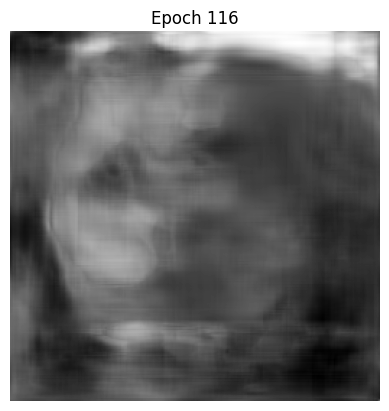

Epochs:  15%|█▌        | 116/751 [47:09<3:54:00, 22.11s/it]

Epoch 117/751


Epochs:  16%|█▌        | 117/751 [47:30<3:50:50, 21.85s/it]

Epoch 118/751


Epochs:  16%|█▌        | 118/751 [47:52<3:48:23, 21.65s/it]

Epoch 119/751


Epochs:  16%|█▌        | 119/751 [48:13<3:46:33, 21.51s/it]

Epoch 120/751


Epochs:  16%|█▌        | 120/751 [48:34<3:45:10, 21.41s/it]

Epoch 121/751
Discriminator Loss (real): 0.00020054473
GAN Loss (G): 10.052398
GAN Loss (D): 10.051866


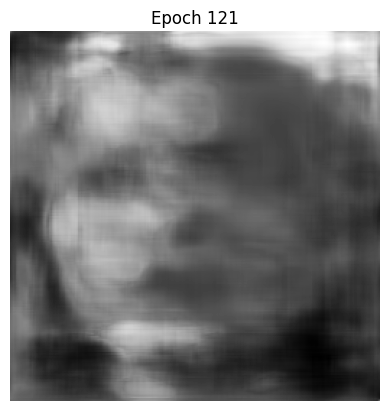

Epochs:  16%|█▌        | 121/751 [48:58<3:52:32, 22.15s/it]

Epoch 122/751


Epochs:  16%|█▌        | 122/751 [49:19<3:49:11, 21.86s/it]

Epoch 123/751


Epochs:  16%|█▋        | 123/751 [49:40<3:46:33, 21.65s/it]

Epoch 124/751


Epochs:  17%|█▋        | 124/751 [50:01<3:45:14, 21.55s/it]

Epoch 125/751


Epochs:  17%|█▋        | 125/751 [50:23<3:44:05, 21.48s/it]

Epoch 126/751
Discriminator Loss (real): 0.00019258697
GAN Loss (G): 10.099029
GAN Loss (D): 10.0985155


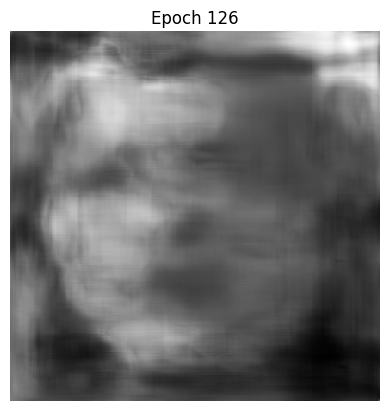

Epochs:  17%|█▋        | 126/751 [50:47<3:51:04, 22.18s/it]

Epoch 127/751


Epochs:  17%|█▋        | 127/751 [51:08<3:47:41, 21.89s/it]

Epoch 128/751


Epochs:  17%|█▋        | 128/751 [51:29<3:44:50, 21.65s/it]

Epoch 129/751


Epochs:  17%|█▋        | 129/751 [51:50<3:43:11, 21.53s/it]

Epoch 130/751


Epochs:  17%|█▋        | 130/751 [52:11<3:41:56, 21.44s/it]

Epoch 131/751
Discriminator Loss (real): 0.00018523665
GAN Loss (G): 10.145183
GAN Loss (D): 10.144686


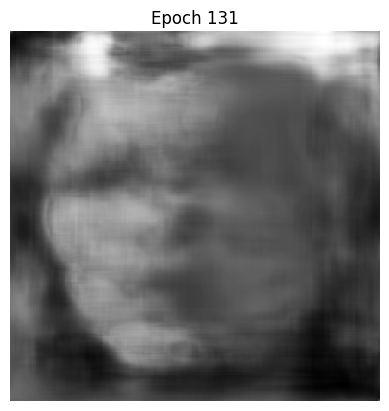

Epochs:  17%|█▋        | 131/751 [52:35<3:48:49, 22.14s/it]

Epoch 132/751


Epochs:  18%|█▊        | 132/751 [52:56<3:45:26, 21.85s/it]

Epoch 133/751


Epochs:  18%|█▊        | 133/751 [53:17<3:42:54, 21.64s/it]

Epoch 134/751


Epochs:  18%|█▊        | 134/751 [53:39<3:41:05, 21.50s/it]

Epoch 135/751


Epochs:  18%|█▊        | 135/751 [54:00<3:39:35, 21.39s/it]

Epoch 136/751
Discriminator Loss (real): 0.0001784267
GAN Loss (G): 10.190845
GAN Loss (D): 10.190365


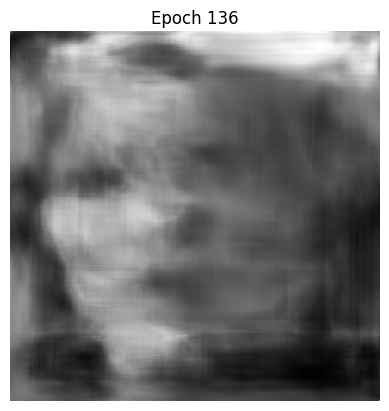

Epochs:  18%|█▊        | 136/751 [54:24<3:46:43, 22.12s/it]

Epoch 137/751


Epochs:  18%|█▊        | 137/751 [54:45<3:43:28, 21.84s/it]

Epoch 138/751


Epochs:  18%|█▊        | 138/751 [55:06<3:41:22, 21.67s/it]

Epoch 139/751


Epochs:  19%|█▊        | 139/751 [55:27<3:39:50, 21.55s/it]

Epoch 140/751


Epochs:  19%|█▊        | 140/751 [55:49<3:39:05, 21.51s/it]

Epoch 141/751
Discriminator Loss (real): 0.00017209967
GAN Loss (G): 10.232756
GAN Loss (D): 10.23229


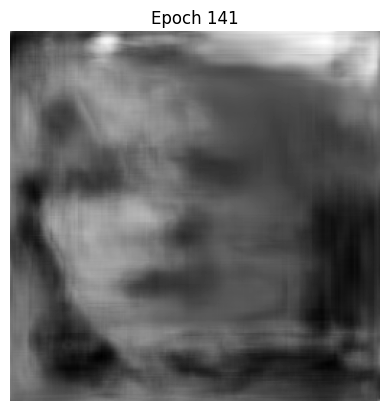

Epochs:  19%|█▉        | 141/751 [56:13<3:46:05, 22.24s/it]

Epoch 142/751


Epochs:  19%|█▉        | 142/751 [56:34<3:42:21, 21.91s/it]

Epoch 143/751


Epochs:  19%|█▉        | 143/751 [56:55<3:39:42, 21.68s/it]

Epoch 144/751


Epochs:  19%|█▉        | 144/751 [57:16<3:37:34, 21.51s/it]

Epoch 145/751


Epochs:  19%|█▉        | 145/751 [57:37<3:36:01, 21.39s/it]

Epoch 146/751
Discriminator Loss (real): 0.00016620592
GAN Loss (G): 10.274727
GAN Loss (D): 10.274276


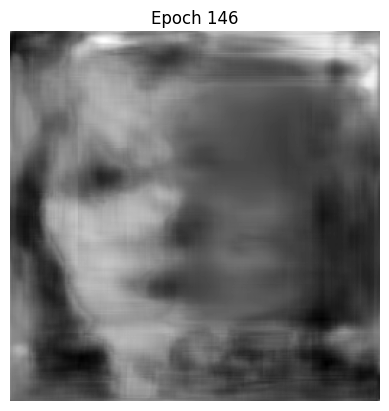

Epochs:  19%|█▉        | 146/751 [58:01<3:43:04, 22.12s/it]

Epoch 147/751


Epochs:  20%|█▉        | 147/751 [58:22<3:40:05, 21.86s/it]

Epoch 148/751


Epochs:  20%|█▉        | 148/751 [58:44<3:38:22, 21.73s/it]

Epoch 149/751


Epochs:  20%|█▉        | 149/751 [59:05<3:37:04, 21.64s/it]

Epoch 150/751


Epochs:  20%|█▉        | 150/751 [59:27<3:36:15, 21.59s/it]

Epoch 151/751
Discriminator Loss (real): 0.00016070248
GAN Loss (G): 10.318363
GAN Loss (D): 10.317926


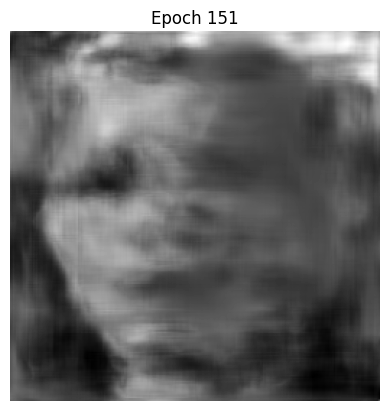

Epochs:  20%|██        | 151/751 [59:51<3:43:33, 22.36s/it]

Epoch 152/751


Epochs:  20%|██        | 152/751 [1:00:12<3:40:30, 22.09s/it]

Epoch 153/751


Epochs:  20%|██        | 153/751 [1:00:34<3:38:22, 21.91s/it]

Epoch 154/751


Epochs:  21%|██        | 154/751 [1:00:55<3:36:38, 21.77s/it]

Epoch 155/751


Epochs:  21%|██        | 155/751 [1:01:17<3:35:22, 21.68s/it]

Epoch 156/751
Discriminator Loss (real): 0.00015555181
GAN Loss (G): 10.360689
GAN Loss (D): 10.360264


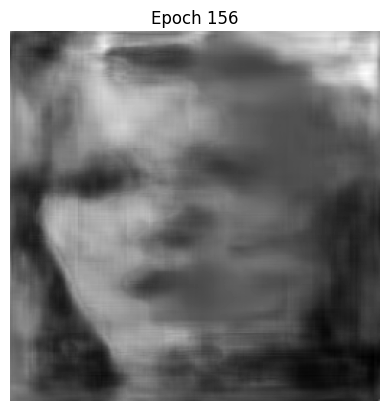

Epochs:  21%|██        | 156/751 [1:01:41<3:42:32, 22.44s/it]

Epoch 157/751


Epochs:  21%|██        | 157/751 [1:02:02<3:38:26, 22.06s/it]

Epoch 158/751


Epochs:  21%|██        | 158/751 [1:02:23<3:35:29, 21.80s/it]

Epoch 159/751


Epochs:  21%|██        | 159/751 [1:02:44<3:33:22, 21.63s/it]

Epoch 160/751


Epochs:  21%|██▏       | 160/751 [1:03:06<3:31:43, 21.49s/it]

Epoch 161/751
Discriminator Loss (real): 0.00015072104
GAN Loss (G): 10.40127
GAN Loss (D): 10.400857


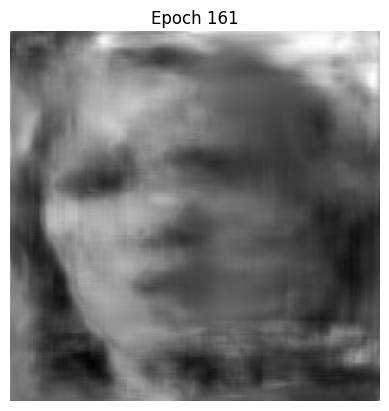

Epochs:  21%|██▏       | 161/751 [1:03:30<3:38:26, 22.22s/it]

Epoch 162/751


Epochs:  22%|██▏       | 162/751 [1:03:51<3:36:09, 22.02s/it]

Epoch 163/751


Epochs:  22%|██▏       | 163/751 [1:04:13<3:34:23, 21.88s/it]

Epoch 164/751


Epochs:  22%|██▏       | 164/751 [1:04:34<3:33:01, 21.77s/it]

Epoch 165/751


Epochs:  22%|██▏       | 165/751 [1:04:56<3:31:58, 21.70s/it]

Epoch 166/751
Discriminator Loss (real): 0.00014618125
GAN Loss (G): 10.442405
GAN Loss (D): 10.442001


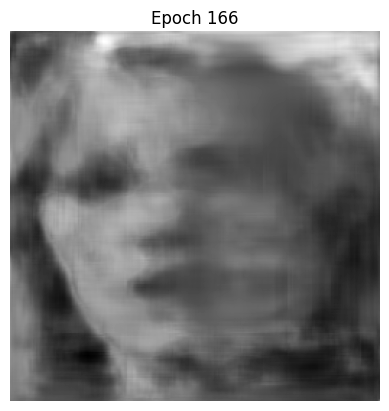

Epochs:  22%|██▏       | 166/751 [1:05:20<3:39:02, 22.47s/it]

Epoch 167/751


Epochs:  22%|██▏       | 167/751 [1:05:41<3:35:40, 22.16s/it]

Epoch 168/751


Epochs:  22%|██▏       | 168/751 [1:06:03<3:33:14, 21.95s/it]

Epoch 169/751


Epochs:  23%|██▎       | 169/751 [1:06:24<3:31:24, 21.79s/it]

Epoch 170/751


Epochs:  23%|██▎       | 170/751 [1:06:46<3:29:53, 21.68s/it]

Epoch 171/751
Discriminator Loss (real): 0.00014190694
GAN Loss (G): 10.484292
GAN Loss (D): 10.483899


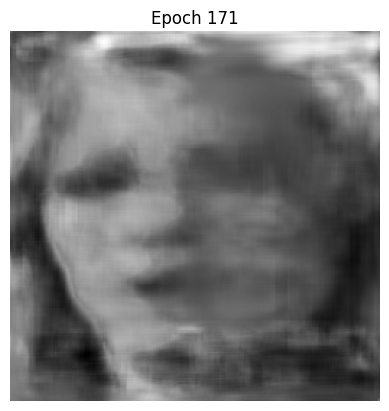

Epochs:  23%|██▎       | 171/751 [1:07:10<3:36:33, 22.40s/it]

Epoch 172/751


Epochs:  23%|██▎       | 172/751 [1:07:31<3:33:27, 22.12s/it]

Epoch 173/751


Epochs:  23%|██▎       | 173/751 [1:07:53<3:31:02, 21.91s/it]

Epoch 174/751


Epochs:  23%|██▎       | 174/751 [1:08:14<3:29:12, 21.76s/it]

Epoch 175/751


Epochs:  23%|██▎       | 175/751 [1:08:35<3:27:49, 21.65s/it]

Epoch 176/751
Discriminator Loss (real): 0.0001378755
GAN Loss (G): 10.525899
GAN Loss (D): 10.5255165


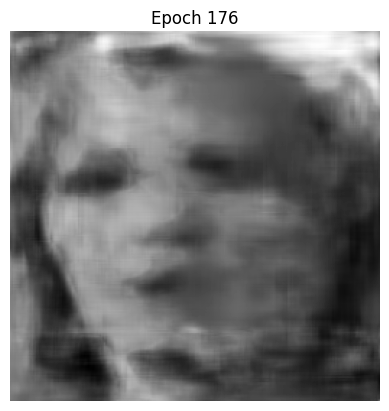

Epochs:  23%|██▎       | 176/751 [1:09:00<3:34:38, 22.40s/it]

Epoch 177/751


Epochs:  24%|██▎       | 177/751 [1:09:21<3:30:51, 22.04s/it]

Epoch 178/751


Epochs:  24%|██▎       | 178/751 [1:09:42<3:28:02, 21.78s/it]

Epoch 179/751


Epochs:  24%|██▍       | 179/751 [1:10:03<3:26:03, 21.61s/it]

Epoch 180/751


Epochs:  24%|██▍       | 180/751 [1:10:24<3:24:27, 21.49s/it]

Epoch 181/751
Discriminator Loss (real): 0.00013406678
GAN Loss (G): 10.56779
GAN Loss (D): 10.567415


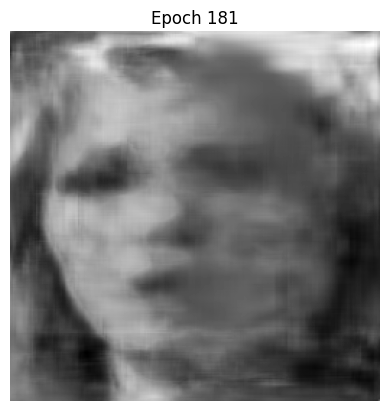

Epochs:  24%|██▍       | 181/751 [1:10:48<3:30:56, 22.20s/it]

Epoch 182/751


Epochs:  24%|██▍       | 182/751 [1:11:10<3:28:27, 21.98s/it]

Epoch 183/751


Epochs:  24%|██▍       | 183/751 [1:11:31<3:26:27, 21.81s/it]

Epoch 184/751


Epochs:  25%|██▍       | 184/751 [1:11:53<3:25:02, 21.70s/it]

Epoch 185/751


Epochs:  25%|██▍       | 185/751 [1:12:14<3:23:55, 21.62s/it]

Epoch 186/751
Discriminator Loss (real): 0.00013046284
GAN Loss (G): 10.6092415
GAN Loss (D): 10.608875


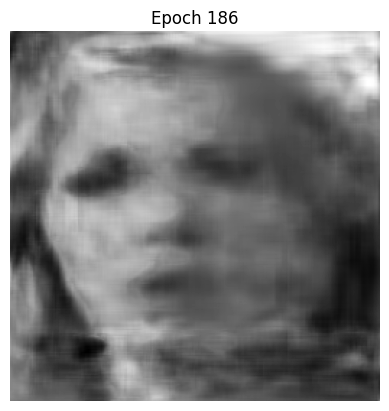

Epochs:  25%|██▍       | 186/751 [1:12:38<3:30:54, 22.40s/it]

Epoch 187/751


Epochs:  25%|██▍       | 187/751 [1:13:00<3:27:50, 22.11s/it]

Epoch 188/751


Epochs:  25%|██▌       | 188/751 [1:13:21<3:25:31, 21.90s/it]

Epoch 189/751


Epochs:  25%|██▌       | 189/751 [1:13:43<3:23:49, 21.76s/it]

Epoch 190/751


Epochs:  25%|██▌       | 190/751 [1:14:04<3:22:34, 21.67s/it]

Epoch 191/751
Discriminator Loss (real): 0.00012704758
GAN Loss (G): 10.650617
GAN Loss (D): 10.650259


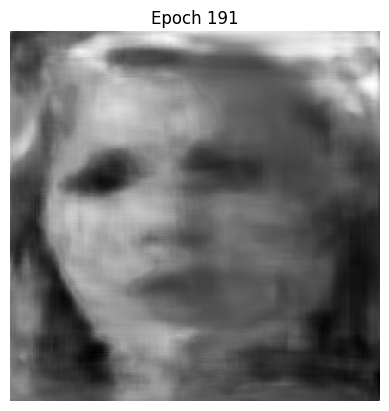

Epochs:  25%|██▌       | 191/751 [1:14:28<3:29:05, 22.40s/it]

Epoch 192/751


Epochs:  26%|██▌       | 192/751 [1:14:49<3:25:21, 22.04s/it]

Epoch 193/751


Epochs:  26%|██▌       | 193/751 [1:15:10<3:22:37, 21.79s/it]

Epoch 194/751


Epochs:  26%|██▌       | 194/751 [1:15:32<3:20:36, 21.61s/it]

Epoch 195/751


Epochs:  26%|██▌       | 195/751 [1:15:53<3:19:06, 21.49s/it]

Epoch 196/751
Discriminator Loss (real): 0.00012380656
GAN Loss (G): 10.691821
GAN Loss (D): 10.691471


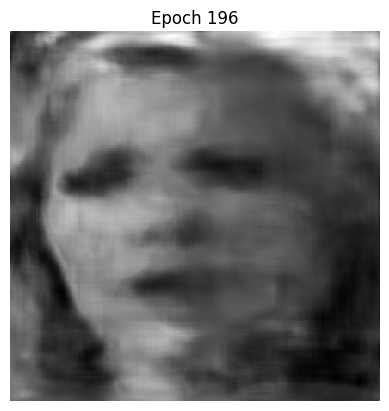

Epochs:  26%|██▌       | 196/751 [1:16:17<3:25:32, 22.22s/it]

Epoch 197/751


Epochs:  26%|██▌       | 197/751 [1:16:38<3:23:00, 21.99s/it]

Epoch 198/751


Epochs:  26%|██▋       | 198/751 [1:17:00<3:21:07, 21.82s/it]

Epoch 199/751


Epochs:  26%|██▋       | 199/751 [1:17:21<3:19:40, 21.70s/it]

Epoch 200/751


Epochs:  27%|██▋       | 200/751 [1:17:43<3:18:30, 21.62s/it]

Epoch 201/751
Discriminator Loss (real): 0.00012072681
GAN Loss (G): 10.733482
GAN Loss (D): 10.733141


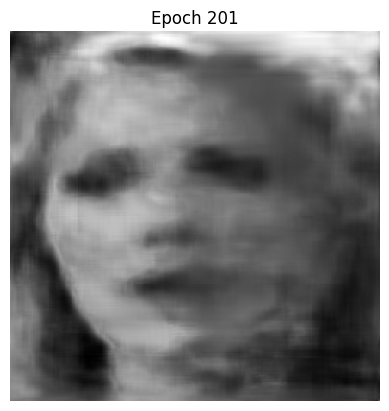

Epochs:  27%|██▋       | 201/751 [1:18:07<3:24:57, 22.36s/it]

Epoch 202/751


Epochs:  27%|██▋       | 202/751 [1:18:28<3:22:00, 22.08s/it]

Epoch 203/751


Epochs:  27%|██▋       | 203/751 [1:18:49<3:19:46, 21.87s/it]

Epoch 204/751


Epochs:  27%|██▋       | 204/751 [1:19:11<3:18:09, 21.74s/it]

Epoch 205/751


Epochs:  27%|██▋       | 205/751 [1:19:32<3:16:54, 21.64s/it]

Epoch 206/751
Discriminator Loss (real): 0.00011779654
GAN Loss (G): 10.774655
GAN Loss (D): 10.774321


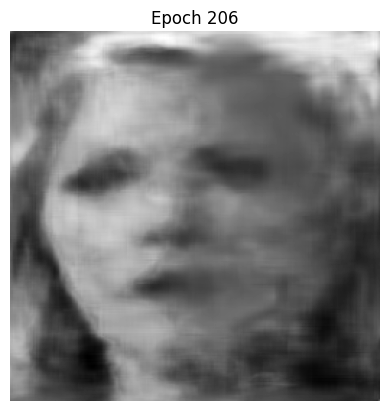

Epochs:  27%|██▋       | 206/751 [1:19:56<3:23:12, 22.37s/it]

Epoch 207/751


Epochs:  28%|██▊       | 207/751 [1:20:18<3:20:22, 22.10s/it]

Epoch 208/751


Epochs:  28%|██▊       | 208/751 [1:20:39<3:18:08, 21.89s/it]

Epoch 209/751


Epochs:  28%|██▊       | 209/751 [1:21:01<3:16:28, 21.75s/it]

Epoch 210/751


Epochs:  28%|██▊       | 210/751 [1:21:22<3:15:19, 21.66s/it]

Epoch 211/751
Discriminator Loss (real): 0.00011500515
GAN Loss (G): 10.8154745
GAN Loss (D): 10.8151455


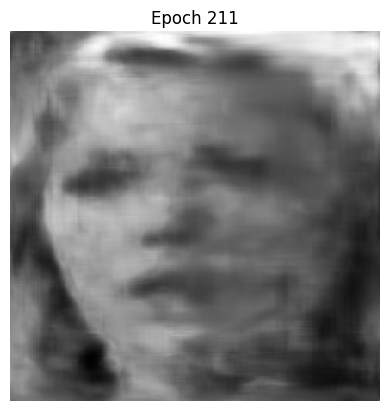

Epochs:  28%|██▊       | 211/751 [1:21:46<3:21:38, 22.40s/it]

Epoch 212/751


Epochs:  28%|██▊       | 212/751 [1:22:07<3:18:04, 22.05s/it]

Epoch 213/751


Epochs:  28%|██▊       | 213/751 [1:22:29<3:15:22, 21.79s/it]

Epoch 214/751


Epochs:  28%|██▊       | 214/751 [1:22:50<3:13:24, 21.61s/it]

Epoch 215/751


Epochs:  29%|██▊       | 215/751 [1:23:11<3:11:58, 21.49s/it]

Epoch 216/751
Discriminator Loss (real): 0.00011234299
GAN Loss (G): 10.856047
GAN Loss (D): 10.855724


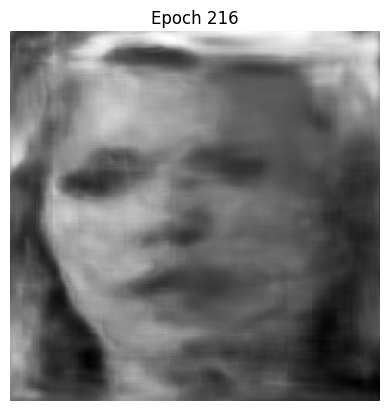

Epochs:  29%|██▉       | 216/751 [1:23:35<3:18:01, 22.21s/it]

Epoch 217/751


Epochs:  29%|██▉       | 217/751 [1:23:56<3:15:33, 21.97s/it]

Epoch 218/751


Epochs:  29%|██▉       | 218/751 [1:24:18<3:13:43, 21.81s/it]

Epoch 219/751


Epochs:  29%|██▉       | 219/751 [1:24:39<3:12:20, 21.69s/it]

Epoch 220/751


Epochs:  29%|██▉       | 220/751 [1:25:01<3:11:15, 21.61s/it]

Epoch 221/751
Discriminator Loss (real): 0.0001098013
GAN Loss (G): 10.895557
GAN Loss (D): 10.895242


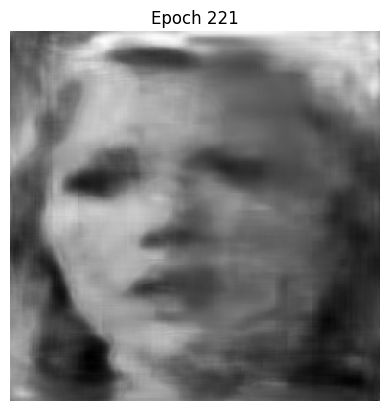

Epochs:  29%|██▉       | 221/751 [1:25:25<3:17:39, 22.38s/it]

Epoch 222/751


Epochs:  30%|██▉       | 222/751 [1:25:46<3:14:50, 22.10s/it]

Epoch 223/751


Epochs:  30%|██▉       | 223/751 [1:26:08<3:12:38, 21.89s/it]

Epoch 224/751


Epochs:  30%|██▉       | 224/751 [1:26:29<3:11:11, 21.77s/it]

Epoch 225/751


Epochs:  30%|██▉       | 225/751 [1:26:51<3:09:55, 21.66s/it]

Epoch 226/751
Discriminator Loss (real): 0.00010737206
GAN Loss (G): 10.935257
GAN Loss (D): 10.934946


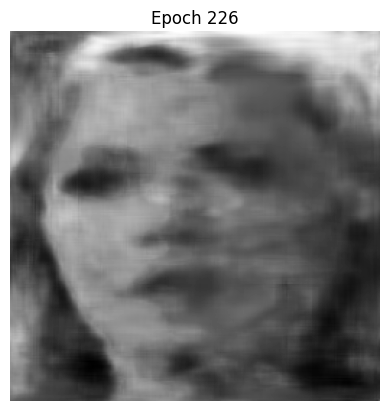

Epochs:  30%|███       | 226/751 [1:27:15<3:16:01, 22.40s/it]

Epoch 227/751


Epochs:  30%|███       | 227/751 [1:27:36<3:12:52, 22.09s/it]

Epoch 228/751


Epochs:  30%|███       | 228/751 [1:27:57<3:10:29, 21.85s/it]

Epoch 229/751


Epochs:  30%|███       | 229/751 [1:28:19<3:08:37, 21.68s/it]

Epoch 230/751


Epochs:  31%|███       | 230/751 [1:28:40<3:07:17, 21.57s/it]

Epoch 231/751
Discriminator Loss (real): 0.000105048
GAN Loss (G): 10.9745865
GAN Loss (D): 10.974281


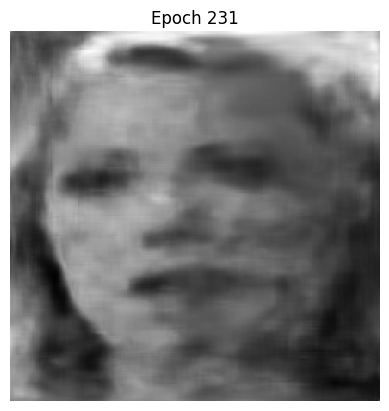

Epochs:  31%|███       | 231/751 [1:29:04<3:13:16, 22.30s/it]

Epoch 232/751


Epochs:  31%|███       | 232/751 [1:29:25<3:10:40, 22.04s/it]

Epoch 233/751


Epochs:  31%|███       | 233/751 [1:29:47<3:08:45, 21.86s/it]

Epoch 234/751


Epochs:  31%|███       | 234/751 [1:30:08<3:07:19, 21.74s/it]

Epoch 235/751


Epochs:  31%|███▏      | 235/751 [1:30:30<3:06:15, 21.66s/it]

Epoch 236/751
Discriminator Loss (real): 0.0001028224
GAN Loss (G): 11.013098
GAN Loss (D): 11.012798


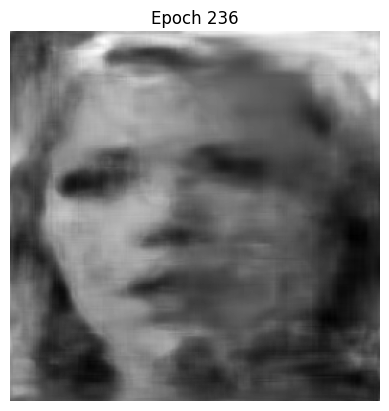

Epochs:  31%|███▏      | 236/751 [1:30:54<3:12:18, 22.41s/it]

Epoch 237/751


Epochs:  32%|███▏      | 237/751 [1:31:15<3:09:44, 22.15s/it]

Epoch 238/751


Epochs:  32%|███▏      | 238/751 [1:31:37<3:07:54, 21.98s/it]

Epoch 239/751


Epochs:  32%|███▏      | 239/751 [1:31:59<3:06:25, 21.85s/it]

Epoch 240/751


Epochs:  32%|███▏      | 240/751 [1:32:20<3:05:16, 21.76s/it]

Epoch 241/751
Discriminator Loss (real): 0.00010068916
GAN Loss (G): 11.050993
GAN Loss (D): 11.050698


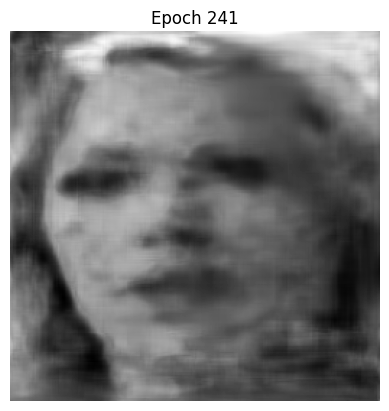

Epochs:  32%|███▏      | 241/751 [1:32:44<3:11:18, 22.51s/it]

Epoch 242/751


Epochs:  32%|███▏      | 242/751 [1:33:06<3:07:37, 22.12s/it]

Epoch 243/751


Epochs:  32%|███▏      | 243/751 [1:33:27<3:04:54, 21.84s/it]

Epoch 244/751


Epochs:  32%|███▏      | 244/751 [1:33:48<3:02:54, 21.65s/it]

Epoch 245/751


Epochs:  33%|███▎      | 245/751 [1:34:09<3:01:24, 21.51s/it]

Epoch 246/751
Discriminator Loss (real): 9.864263e-05
GAN Loss (G): 11.088624
GAN Loss (D): 11.088336


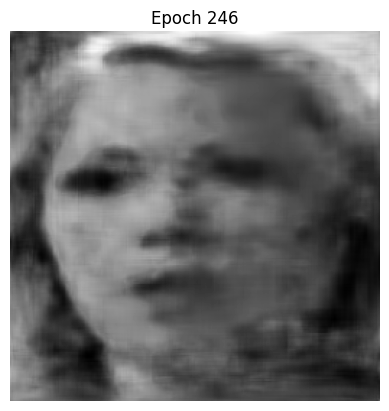

Epochs:  33%|███▎      | 246/751 [1:34:33<3:07:14, 22.25s/it]

Epoch 247/751


Epochs:  33%|███▎      | 247/751 [1:34:55<3:04:52, 22.01s/it]

Epoch 248/751


In [ ]:
train_motion_model(X = (X0, X1),
                   Y = Y,
                   generator = models['generator_model'],
                   gan_model = models['gan'],
                   discriminator = models['discriminator'],
                   save_path = '../../../../kaggle/working/',
                   batch_size = 16,
                   epochs = 751,
                   preview_interval = 5
                  )

In [ ]:
import os

output_folder = "../../kaggle/working/output_gif"
os.makedirs(output_folder, exist_ok=True)
models['generator_model'].layers[-1].batch_size = 1

start_frame, end_frame = 50, 100
for frame_number in range(start_frame, end_frame):
    output = models['generator_model']((X0[frame_number: frame_number+1],
                                  X1[frame_number: frame_number+1]))
    plt.imshow(output[0])
    plt.show()

In [ ]:
quit